<a href="https://colab.research.google.com/github/Rhodham96/AIAssistantStreamer/blob/main/EuroSatCNN/Update/CNNEuroSat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EuroSat classification

### References

Helber, P., Bischke, B., Dengel, A., & Borth, D. (2017). *EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification*. arXiv preprint [arXiv:1709.00029](https://arxiv.org/abs/1709.00029).

In [ ]:
!pip install huggingface_hub[hf_xet]

In [ ]:
!pip install --upgrade datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 20.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 37.6 MB/s eta 0:00:00


In [ ]:
import PIL
from PIL import Image
import torch
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [ ]:
from datasets import load_dataset
EuroSAT_MSI = load_dataset("blanchon/EuroSAT_MSI", cache_dir="./hf_cache", streaming=False)
print(EuroSAT_MSI)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.46k [00:00<?, ?B/s]

data/train-00000-of-00004.parquet:   0%|          | 0.00/354M [00:00<?, ?B/s]

data/train-00001-of-00004.parquet:   0%|          | 0.00/360M [00:00<?, ?B/s]

data/train-00002-of-00004.parquet:   0%|          | 0.00/360M [00:00<?, ?B/s]

data/train-00003-of-00004.parquet:   0%|          | 0.00/351M [00:00<?, ?B/s]

data/test-00000-of-00002.parquet:   0%|          | 0.00/238M [00:00<?, ?B/s]

data/test-00001-of-00002.parquet:   0%|          | 0.00/238M [00:00<?, ?B/s]

data/validation-00000-of-00002.parquet:   0%|          | 0.00/237M [00:00<?, ?B/s]

data/validation-00001-of-00002.parquet:   0%|          | 0.00/242M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16200 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5400 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5400 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 16200
    })
    test: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 5400
    })
    validation: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 5400
    })
})


In [ ]:
from collections import Counter

# Get all labels from the dataset
labels = EuroSAT_MSI["train"]["label"]

# Count occurrences
label_counts = Counter(labels)

# Map IDs to string labels
label_names = EuroSAT_MSI['train'].features['label'].names
label_distribution = {label_names[k]: v for k, v in label_counts.items()}

# Print nicely
for label, count in label_distribution.items():
    print(f"{label}: {count}")

Annual Crop: 1791
Forest: 1787
Herbaceous Vegetation: 1799
Highway: 1505
Industrial Buildings: 1492
Pasture: 1195
Permanent Crop: 1481
Residential Buildings: 1863
River: 1460
SeaLake: 1827


## Transform in RGB

In [ ]:
def load_rgb_from_multispectral_sample(numpy_array):
        """
        Takes a NumPy array with 13 multispectral bands and returns a scaled RGB NumPy array.
        Equivalent to loading bands 4-3-2 and scaling as GDAL would.
        """
        import numpy as np

        # GDAL-style scaling: scale 0–2750 -> 1–255
        def scale_band(band):
            band = np.clip((band / 2750) * 255, 0, 255)
            return band.astype(np.uint8)

        # Bands 4 (red), 3 (green), 2 (blue) => index 3, 2, 1 in 0-based
        bands = [3, 2, 1]

        # Ensure the input is a NumPy array
        if not isinstance(numpy_array, np.ndarray):
             raise TypeError("Input must be a NumPy array")

        # Check if the array has the expected number of channels (13)
        if numpy_array.shape[-1] != 13:
             raise ValueError(f"Input array must have 13 channels, but got {numpy_array.shape[-1]}")

        # Extract and scale the RGB bands from the NumPy array
        rgb = np.stack([scale_band(numpy_array[:, :, b]) for b in bands], axis=-1)

        return rgb

In [ ]:
def load_rgb_from_transformed_tensor(tensor_image):
    """
    Takes a torch.Tensor with 13 multispectral bands (C, H, W) and returns a scaled RGB NumPy array.
    """
    if not isinstance(tensor_image, torch.Tensor):
        raise TypeError("Input must be a torch.Tensor")
    if tensor_image.shape[0] != 13:
        raise ValueError(f"Expected 13 channels, got {tensor_image.shape[0]}")

    # Convert to NumPy (C, H, W) → (H, W, C)
    np_image = tensor_image.numpy()
    np_image = np.transpose(np_image, (1, 2, 0))  # (H, W, 13)

    # Bands 4-3-2 → index 3, 2, 1
    bands = [3, 2, 1]

    def scale_band(band):
        band = np.clip((band * 255), 0, 255)
        return band.astype(np.uint8)

    rgb = np.stack([scale_band(np_image[:, :, b]) for b in bands], axis=-1)  # (H, W, 3)

    return rgb

Number of classes : 10
Name of classes : ['Annual Crop', 'Forest', 'Herbaceous Vegetation', 'Highway', 'Industrial Buildings', 'Pasture', 'Permanent Crop', 'Residential Buildings', 'River', 'SeaLake']
Type of 'image' after extraction: <class 'numpy.ndarray'>
Shape of 'image' if it's a NumPy array: (64, 64, 13)


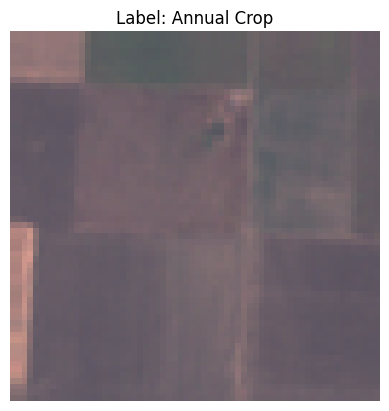

In [ ]:
EuroSAT_MSI.set_transform(lambda x: {
    'image': np.array(x['image']), # Store as NumPy array
    'label': x['label']
})

# Get a sample from the training set (the first image)
sample = EuroSAT_MSI["train"][0]

# Extract the image and label
image = sample['image']
label_names = EuroSAT_MSI['train'].features['label'].names
num_classes = len(label_names)
label = EuroSAT_MSI["train"].features["label"].int2str(sample['label'])

# --- Add these print statements to inspect the data ---
print("Number of classes :", num_classes)
print("Name of classes :", label_names)
print(f"Type of 'image' after extraction: {type(image)}")
if isinstance(image, np.ndarray):
    print(f"Shape of 'image' if it's a NumPy array: {image.shape}")
# --- End of print statements ---

# Ensure the image data is a NumPy array
if not isinstance(image, np.ndarray):
    # This should ideally not be needed if the transform is working,
    # but it adds robustness.
    image = np.array(image)

# Convert the multispectral NumPy array to an RGB NumPy array using your modified function
# Make sure load_rgb_from_multispectral_sample is defined as in the previous answer
rgb_img = load_rgb_from_multispectral_sample(image)

# Display the image
plt.imshow(rgb_img)
plt.title(f"Label: {label}")
plt.axis("off") # Hide axes
plt.show()

## CNN Model

In [ ]:
import torch
import torch.nn as nn


class EuroSATCNN(nn.Module):
    def __init__(self, num_classes, img_height=64, img_width=64):
        super(EuroSATCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(13, 128, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(128, 64, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 32, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 16, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        with torch.no_grad():
            dummy_input = torch.randn(1, 13, img_height, img_width)
            out = self.features(dummy_input)
            fc1_input_size = out.view(1, -1).shape[1]

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(fc1_input_size, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)

        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = EuroSATCNN(num_classes)
print(model)

EuroSATCNN(
  (features): Sequential(
    (0): Conv2d(13, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(128, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=144, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)


## RESNET 18
- Test Accuracy: 87.30%
- Average Test Loss: 0.4189
- F1 Score: 0.8742

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet18
from torchvision.models import ResNet18_Weights

model = resnet18(weights=None)  # Set to pretrained weights if input is 3-channels
model.conv1 = nn.Conv2d(13, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Modify for 13 bands
model.fc = nn.Linear(model.fc.in_features, num_classes)
print(model)

## RESNET 18 + DROPOUT
- Test Accuracy: 90.80%
- Average Test Loss: 0.2630
- F1 Score: 0.9069

In [ ]:
import torch.nn as nn
from torchvision.models import resnet18

class ResNet18_Dropout(nn.Module):
    def __init__(self, in_channels, num_classes, dropout_rate=0.3):
        super().__init__()
        self.model = resnet18(weights=None)
        self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)

model = ResNet18_Dropout(in_channels=13, num_classes=num_classes)
print(model)

ResNet18_Dropout(
  (model): ResNet(
    (conv1): Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [ ]:
label_names = EuroSAT_MSI["train"].features['label'].names
label2id = {name: i for i, name in enumerate(label_names)}
id2label = {v: k for k, v in label2id.items()}

In [ ]:
"""def transform_multispectral_map(example):
    image = np.array(example["image"], dtype=np.float32)

    if image.ndim != 3 or image.shape[2] != 13:
        raise ValueError(f"Expected shape (H, W, 13), got {image.shape}")

    image = image.transpose(2, 0, 1)  # (C=13, H, W)
    image = image / 2750.0
    image = np.clip(image, 0, 1)
    #print(example["label"])
    #example["label"] = label2id[example["label"]]
    #print(example["label"])

    return {
        "image": torch.tensor(image, dtype=torch.float32),
        "label": torch.tensor(example["label"], dtype=torch.long)
    }"""

import numpy as np
import torch
import random

def transform_multispectral_map(example):
    image = np.array(example["image"], dtype=np.float32)

    if image.ndim != 3 or image.shape[2] != 13:
        raise ValueError(f"Expected shape (H, W, 13), got {image.shape}")

    # Normalize
    image = image / 2750.0
    image = np.clip(image, 0, 1)

    # === DATA AUGMENTATION ===
    # Horizontal flip
    if random.random() < 0.5:
        image = np.flip(image, axis=1).copy()

    # Vertical flip
    if random.random() < 0.5:
        image = np.flip(image, axis=0).copy()

    # Rotation (by 90, 180, 270)
    if random.random() < 0.5:
        k = random.choice([1, 2, 3])
        image = np.rot90(image, k=k, axes=(0, 1)).copy()

    # === SHAPE FORMAT ===
    image = image.transpose(2, 0, 1)  # (C=13, H, W)

    return {
        "image": torch.tensor(image, dtype=torch.float32),
        "label": torch.tensor(example["label"], dtype=torch.long)
    }

# Apply transform with map (batched=False for single example processing)
EuroSAT_MSI["train"] = EuroSAT_MSI["train"].map(transform_multispectral_map)
EuroSAT_MSI["validation"] = EuroSAT_MSI["validation"].map(transform_multispectral_map)
EuroSAT_MSI["test"] = EuroSAT_MSI["test"].map(transform_multispectral_map)

# Now set format to torch to get tensors directly
EuroSAT_MSI.set_format(type="torch", columns=["image", "label"])

Map:   0%|          | 0/16200 [00:00<?, ? examples/s]

Map:   0%|          | 0/5400 [00:00<?, ? examples/s]

Map:   0%|          | 0/5400 [00:00<?, ? examples/s]

## DataLoader

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(EuroSAT_MSI["train"], batch_size=32, shuffle=True)
val_dataloader = DataLoader(EuroSAT_MSI["validation"], batch_size=32, shuffle=True)
test_dataloader = DataLoader(EuroSAT_MSI["test"], batch_size=32, shuffle=True)

In [ ]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

criterion = nn.CrossEntropyLoss()  # No softmax in the model
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.to(device)  # Move the model to the correct device

# Initialize TensorBoard
writer = SummaryWriter("logs")

num_epochs = 10

for epoch in range(num_epochs):
    model.train()  # Set to training mode
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch in train_dataloader:
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        train_loss += loss.item()
        _, predicted = outputs.max(1)  # Get predicted class
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

    train_acc = 100 * train_correct / train_total
    train_loss_avg = train_loss / len(train_dataloader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in val_dataloader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total
    val_loss_avg = val_loss / len(val_dataloader)

    sample_tensor = images[0].cpu()
    img = sample_tensor[[3, 2, 1], :, :]  # BGR approximation
    img = img.permute(1, 2, 0).numpy()
    rgb_tensor = np.clip(img, 0, 1)
    label_index = labels[0].item()
    label_name = label_names[label_index]

    # Log to TensorBoard
    writer.add_scalar("Loss/train", train_loss_avg, epoch)
    writer.add_scalar("Accuracy/train", train_acc, epoch)
    writer.add_scalar("Loss/val", val_loss_avg, epoch)
    writer.add_scalar("Accuracy/val", val_acc, epoch)
    #writer.add_image(f"Sample_RGB/{label_name}", rgb_tensor, global_step=0)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss_avg:.4f} - Train Acc: {train_acc:.2f}% - "
          f"Val Loss: {val_loss_avg:.4f} - Val Acc: {val_acc:.2f}%")

Epoch 1/10 - Train Loss: 0.8922 - Train Acc: 69.90% - Val Loss: 1.0502 - Val Acc: 67.07%
✅ New best model (in memory) at epoch 1 with val loss 1.0502
Epoch 2/10 - Train Loss: 0.5402 - Train Acc: 81.99% - Val Loss: 0.8608 - Val Acc: 69.83%
✅ New best model (in memory) at epoch 2 with val loss 0.8608
Epoch 3/10 - Train Loss: 0.4178 - Train Acc: 86.25% - Val Loss: 0.3671 - Val Acc: 87.96%
✅ New best model (in memory) at epoch 3 with val loss 0.3671
Epoch 4/10 - Train Loss: 0.3432 - Train Acc: 88.72% - Val Loss: 1.1474 - Val Acc: 68.89%
Epoch 5/10 - Train Loss: 0.3084 - Train Acc: 89.75% - Val Loss: 0.6809 - Val Acc: 76.98%
Epoch 6/10 - Train Loss: 0.2725 - Train Acc: 90.61% - Val Loss: 0.5059 - Val Acc: 83.89%
Epoch 7/10 - Train Loss: 0.2433 - Train Acc: 91.77% - Val Loss: 0.2516 - Val Acc: 91.70%
✅ New best model (in memory) at epoch 7 with val loss 0.2516
Epoch 8/10 - Train Loss: 0.2171 - Train Acc: 92.69% - Val Loss: 0.4981 - Val Acc: 84.28%
Epoch 9/10 - Train Loss: 0.1947 - Train Acc:

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

<IPython.core.display.Javascript object>

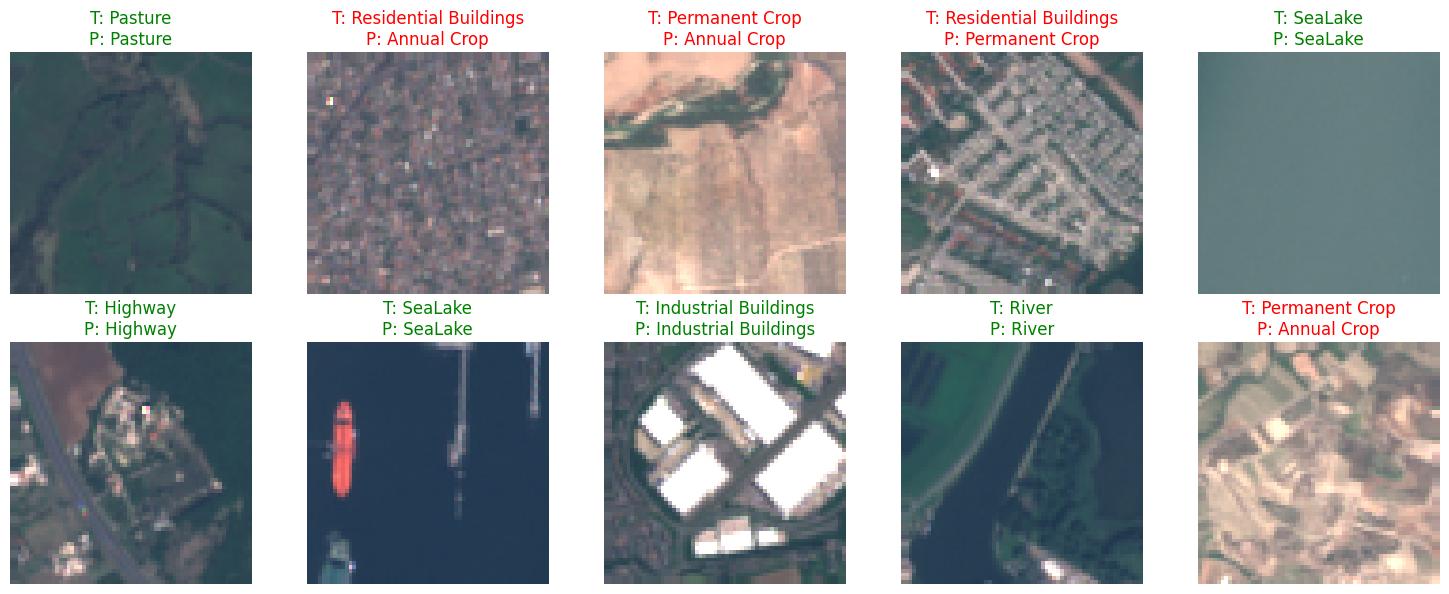

In [ ]:
import random

# Collect enough samples (e.g., from 5 random batches)
num_batches = 5
collected_images = []
collected_labels = []
collected_preds = []
criterion = nn.CrossEntropyLoss()
model.eval()
with torch.no_grad():
    for i, batch in enumerate(val_dataloader):
        if i >= num_batches:
            break
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        outputs = model(images)
        _, preds = outputs.max(1)

        collected_images.append(images.cpu())
        collected_labels.append(labels.cpu())
        collected_preds.append(preds.cpu())

# Concatenate all samples
images = torch.cat(collected_images)
labels = torch.cat(collected_labels)
preds = torch.cat(collected_preds)

# Randomly select 10 indices
indices = random.sample(range(len(images)), 10)

# Prepare for plotting
selected_images = images[indices]
selected_labels = labels[indices]
selected_preds = preds[indices]
image_to_see_layers = selected_images[0]
label_to_see_layers = selected_labels[0]
# Plot
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(10):
    img = selected_images[i][[3, 2, 1], :, :]  # BGR approximation
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    axes[i].imshow(img)
    axes[i].axis("off")
    true_label = id2label[selected_labels[i].item()]
    pred_label = id2label[selected_preds[i].item()]
    color = "green" if pred_label == true_label else "red"
    axes[i].set_title(f"T: {true_label}\nP: {pred_label}", color=color)

plt.tight_layout()
plt.show()

## Save The Model to load later

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.makedirs('/content/drive/MyDrive/models', exist_ok=True)

torch.save(model.state_dict(), '/content/drive/MyDrive/models/CNNEuroSAT.pth')

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/models/CNNEuroSAT.pth'))

model.to(device)
model.eval()

EuroSATCNN(
  (features): Sequential(
    (0): Conv2d(13, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(128, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=144, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)

## Test inference

In [ ]:
from sklearn.metrics import f1_score

model.eval()  # Set to evaluation mode
test_loss = 0.0
test_correct = 0
test_total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)

        test_loss += loss.item() * labels.size(0)
        _, predicted = outputs.max(1)

        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100 * test_correct / test_total
test_loss_avg = test_loss / test_total
f1 = f1_score(all_labels, all_preds, average='weighted')  # Use 'macro' or 'micro' if preferred

print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Average Test Loss: {test_loss_avg:.4f}")
print(f"F1 Score: {f1:.4f}")

Test Accuracy: 82.17%
Average Test Loss: 0.5960
F1 Score: 0.8277


## Export on Hugging Face

In [ ]:
!pip install huggingface_hub

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
import os

repo_dir = "EuroSatCNN"
os.makedirs(repo_dir, exist_ok=True)

# Move model
import shutil
shutil.move("/content/drive/MyDrive/models/CNNEuroSAT.pth", f"{repo_dir}/pytorch_model.bin")

# Add README
with open(f"{repo_dir}/README.md", "w") as f:
    f.write("# EuroSatCNN\nA CNN trained on the EuroSat dataset.")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/models/Resnet18DropoutSentinel.pth'

In [ ]:
from huggingface_hub import create_repo, upload_folder

# Create repo (just for first time)
create_repo("EuroSatCNN", repo_type="model", private=False)

# Upload
upload_folder(
    repo_id="Rhodham96/EuroSatCNN",
    folder_path=repo_dir,
    path_in_repo=".",
    repo_type="model"
)

## How to use it from HF ?

In [ ]:
from huggingface_hub import hf_hub_download
import torch
from model_def import EuroSatCNN

# Download from HF
model_path = hf_hub_download(repo_id="Rhodham96/EuroSatCNN", filename="pytorch_model.bin")
model = EuroSatCNN()
model.load_state_dict(torch.load(model_path))
model.eval()